1. Problem:
  
  Identifying the breed of a dog given an image of a dog.

  When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

2. Data:

  The data we're using is from Kaggle's dog breed identification competition.

  https://www.kaggle.com/c/dog-breed-identification/data

3. Evaluation:

 The evaluation is a file with prediction probabilities for each dog breed of each test image.

 https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

4. Features:
Some information about the data:

 * We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
There are 120 breeds of dogs (this means there are 120 different classes).
 * There are around 10,000+ images in the training set (these images have labels).
 * There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [1]:
# try:
#   # %tensorflow_version only exists in Colab
#   %tensorflow_version 2.3
# except Exception:
#   pass

import tensorflow as tf
import tensorflow_hub as th
print(f'tensor flow version: {tf.__version__}')
print(f'tensor flow hub version: {th.__version__}')
print('GPU', 'available (YESSSS)' if tf.config.list_physical_devices('GPU') else 'not available')



tensor flow version: 2.15.0
tensor flow hub version: 0.16.1
GPU available (YESSSS)


We're going to go through the following TensorFlow/Deep Learning workflow:

Get data ready (download from Kaggle, store, import).
Prepare the data (preprocessing, the 3 sets, X & y).
Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
Evaluating a model (making predictions, comparing them with the ground truth labels).
Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
Save, sharing and reloading your model (once you're happy with the results)

## Accesing the data

In [2]:
# once ran dont need to do that again
# !unzip '/content/drive/MyDrive/Dogvision/dog-breed-identification.zip' -d '/content/drive/MyDrive/Dogvision/'


# Getting our data ready (turning into tensors)

our data has to be in numerical form for our model to work on it

In [3]:
import pandas as pd
labels_csv = pd.read_csv('/content/drive/MyDrive/Dogvision/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: >

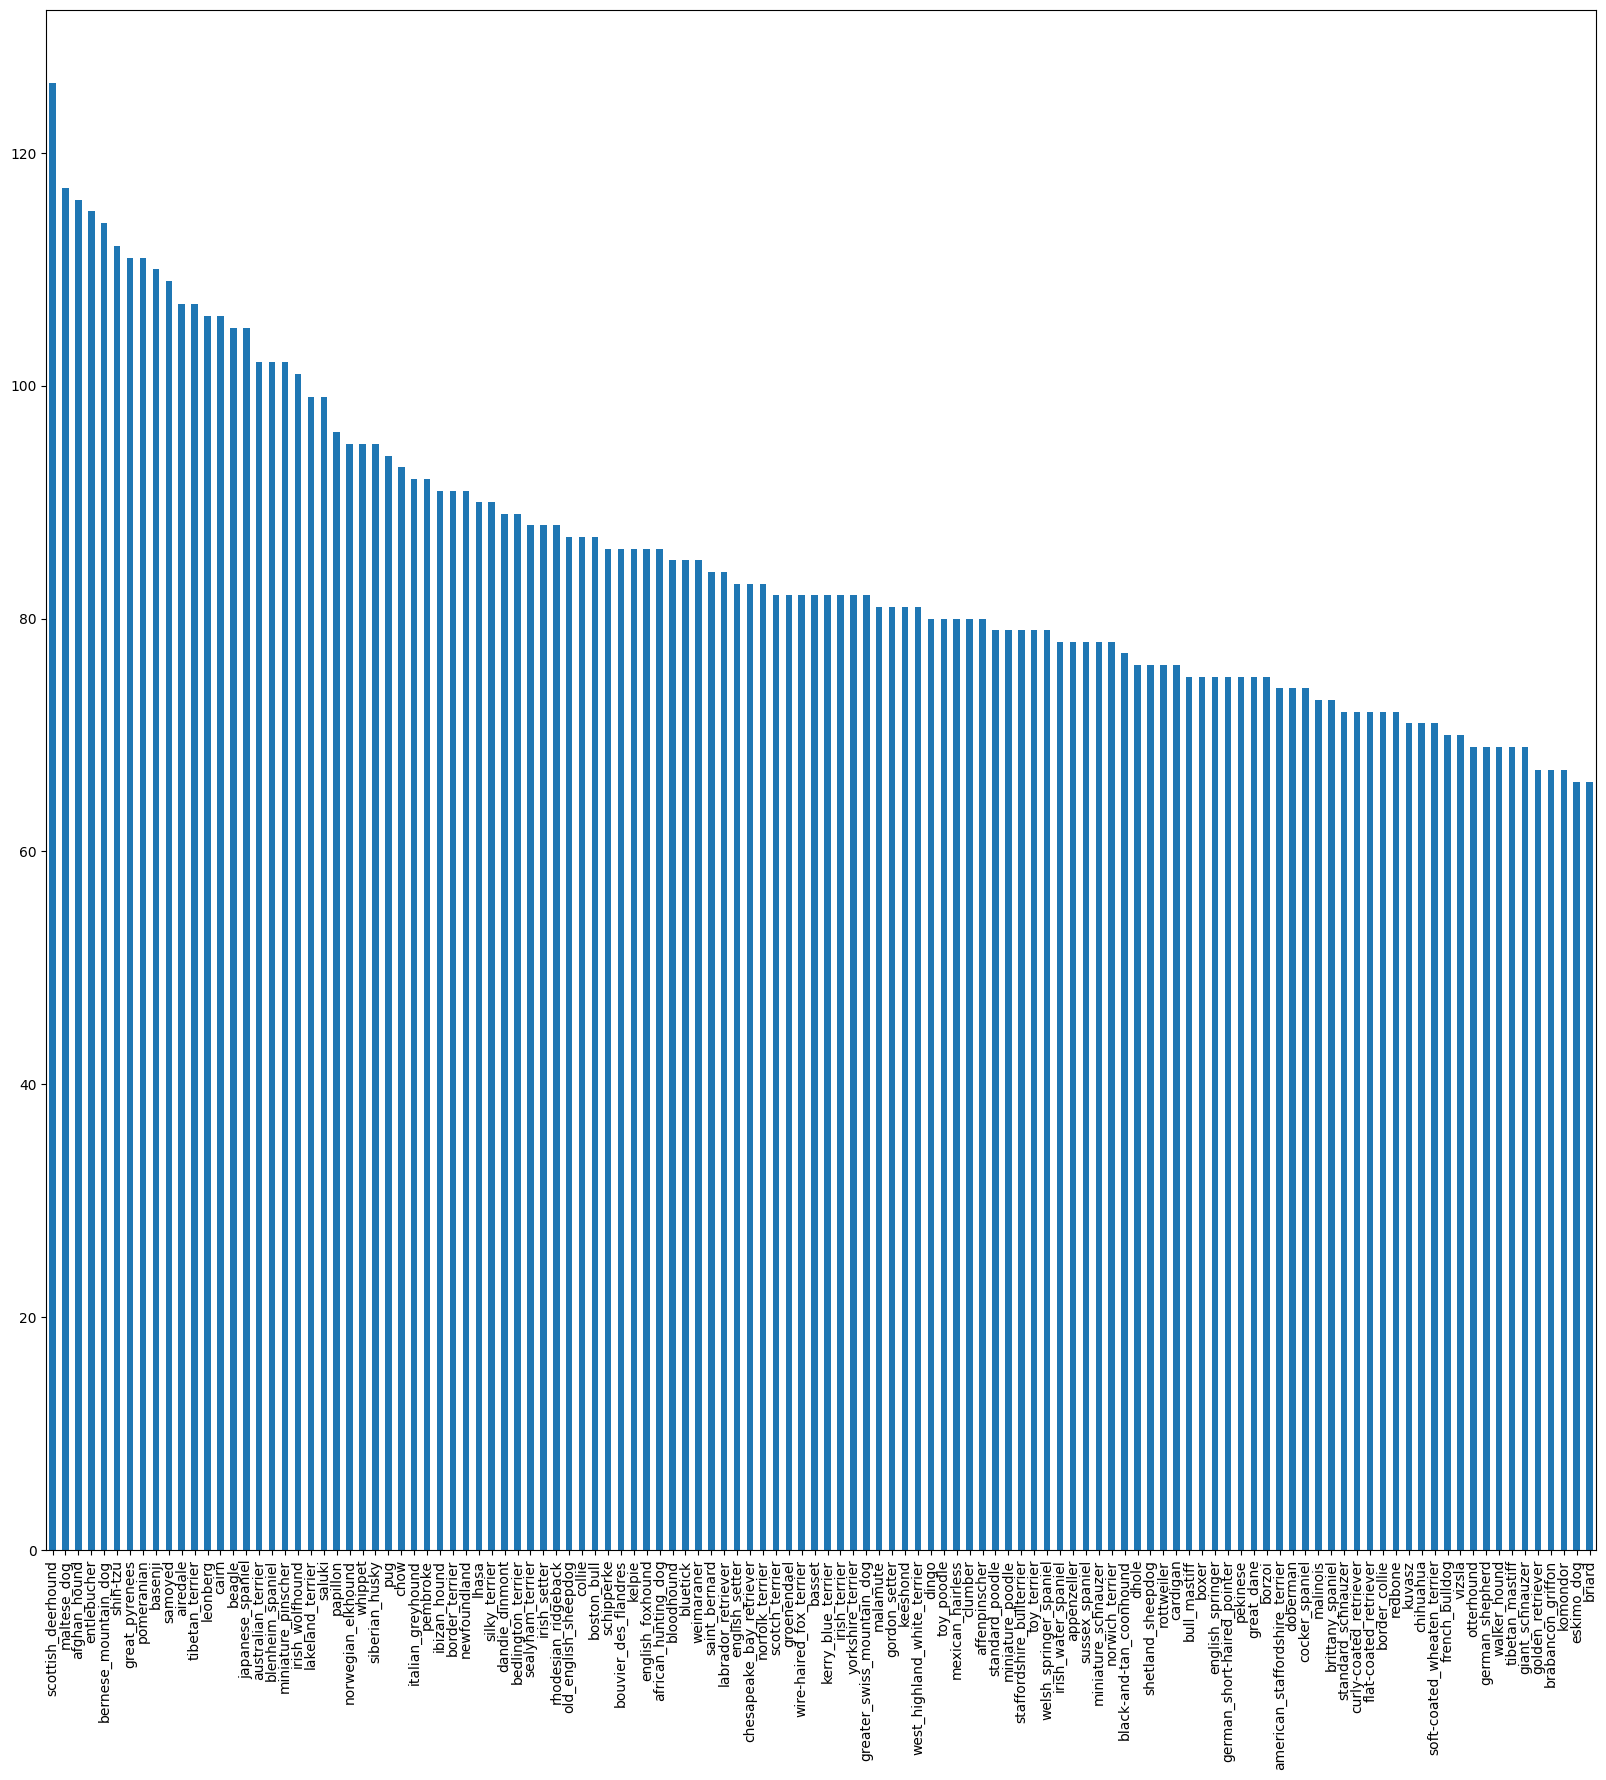

In [5]:
#  how many imgaes are there per class
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 20))

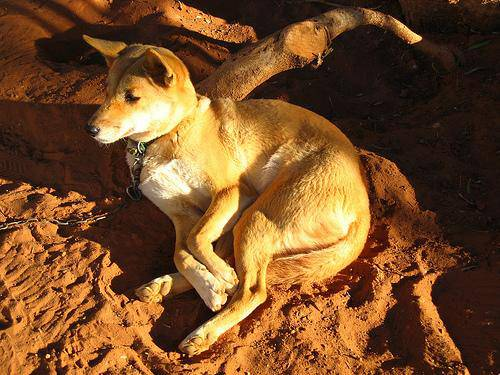

In [6]:
#  to see an image
from IPython.display import Image
Image('/content/drive/MyDrive/Dogvision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

Lets a list of all of our image file pathnames

In [7]:
#  create pathnames from image ID's
filenames = ["drive/MyDrive/Dogvision/train/"+ fname + ".jpg" for fname in labels_csv['id']]

# check the first 10
filenames[:10]

['drive/MyDrive/Dogvision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dogvision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dogvision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dogvision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dogvision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dogvision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dogvision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dogvision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dogvision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dogvision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# check wherher number of filenames matches number of actual image files
import os
if len(os.listdir('drive/MyDrive/Dogvision/train/')) == len(filenames):
  print('filename matches actual amount of files. proceed')
else:  print('Filename do not match actual amount of files, check the target directory')

filename matches actual amount of files. proceed


now that we are done with traing images filepath in a list
lets prepare our labels

In [9]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels) # does the same thing
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
len(labels)

10222

In [11]:
#  check number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else: print('Number of labels does not match number of filenames, check data dictionaries')

Number of labels matches number of filenames


In [12]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [13]:
len(unique_breeds)

120

In [14]:
# Turn every label into a boolean array and store it. it will eventually be converted into numerical values
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [15]:
#  convert boolean into 0 and 1 numerical value
# Example
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs in unique_breeds array
print(boolean_labels[0].argmax()) # index where label occurs in boolean_array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


same thing can be done for entire label array

we are going to start off experimenting with 1000 images and increase as needed

In [16]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: 'slider', min:1000, max:10000, step:1000}

In [17]:
# Lets split our data into train and validation sets
from sklearn.model_selection import train_test_split
x= filenames
y=boolean_labels
# split them into training and valid of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [18]:
x_train[:2], y_train[:2]

(['drive/MyDrive/Dogvision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dogvision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False

Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we are going to wrtie a function which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5.Return the modified `image`


In [19]:
#  convert an image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [20]:
#  convert it into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

now that we have seen what an image look like in a tensor,
lets make the function
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image ( convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [21]:
# Define image size
IMG_SIZE= 224

#  create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image path and turns the image into a Tensor

  """
  # Read in an image file
  image = tf.io.read_file(image_path) # returns image as a readable tensor string


  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green,
  #  Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image







## Turning our data into batches
processing to many images might not fit into memory
so we do it in a batch of 32 images at a time
In order to use TensorFlow effiectively, we need our data in form of Tensor tuples
which look like this :
`(image, label)`

In [22]:
#  function to return a tuple
def get_image_label(image_path, label):
  """
  Takes an image file path name and the asso. label,
  processes the image and returns a tuple of (image, label)
  """

  image = process_image(image_path)
  return image, label

In [23]:
(process_image(x[42]), tf.constant(y[42]))


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [24]:
#  function to create batches
BATCH_SIZE= 32

#  create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x), and label (y) pairs.
  Shuffels the datqa if its traning data but doesnt shuffle if its validation data.
  Also accepts test data as input (no labels)

  """

  #  if the data is a test dataset, we probably dont have labels
  if test_data:
    print("creating a test data batches...")
    data= tf.data.Dataset.from_tensor_slices(tf.constant(x)) # only filepaths(no labels)
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # if the data a valid dataset, dont need to shuffle
  elif valid_data:
     print("creating validation data batches")
     data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepaths
                                                tf.constant(y))) #lables
     data_batch = data.map(get_image_label).batch(BATCH_SIZE)
     return data_batch

  # training dataset
  else:
    print('Creating training data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                              tf.constant(y)))
    # shuffling pathnames and labels before maping image processor fun. is faster than shuffling images after mapping
    data = data.shuffle(buffer_size=len(x))
    # create (image, label) tuple this also turns image path into preprocessed image)
    data = data.map(get_image_label)

    #  thus the training data into  batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [25]:
#  create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches....
creating validation data batches


In [26]:
train_data.element_spec, val_data.element_spec, len(val_data)

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 7)

In [27]:

# visualize the images in a plot to see if functioning of the code is good
import matplotlib.pyplot as plt
#  create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  #  setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for dislpaying 25 images)
  for i in range(25):
  # create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
  # Display an image
    plt.imshow(images[i])
  # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
  # Turn the grid lines off
    plt.axis('off')


In [28]:
train_image, train_labels = next(train_data.as_numpy_iterator())
len(train_image), len(train_labels)

(32, 32)

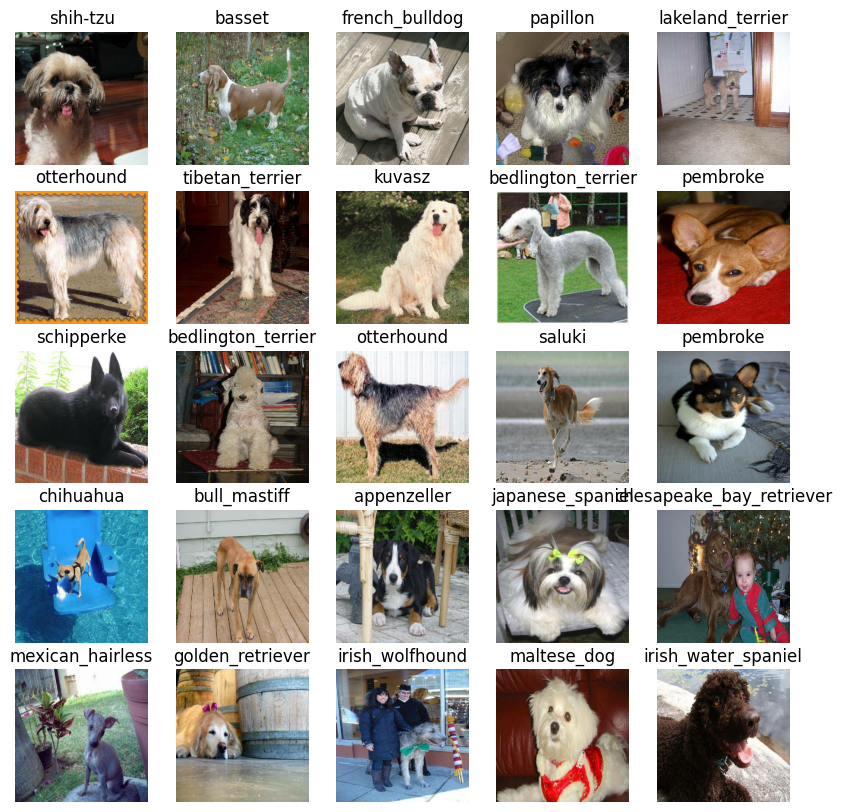

In [29]:
# lets show images of train set
show_25_images(train_image, train_labels)

In [30]:
# images of validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
len(val_images), len(val_labels)

(32, 32)

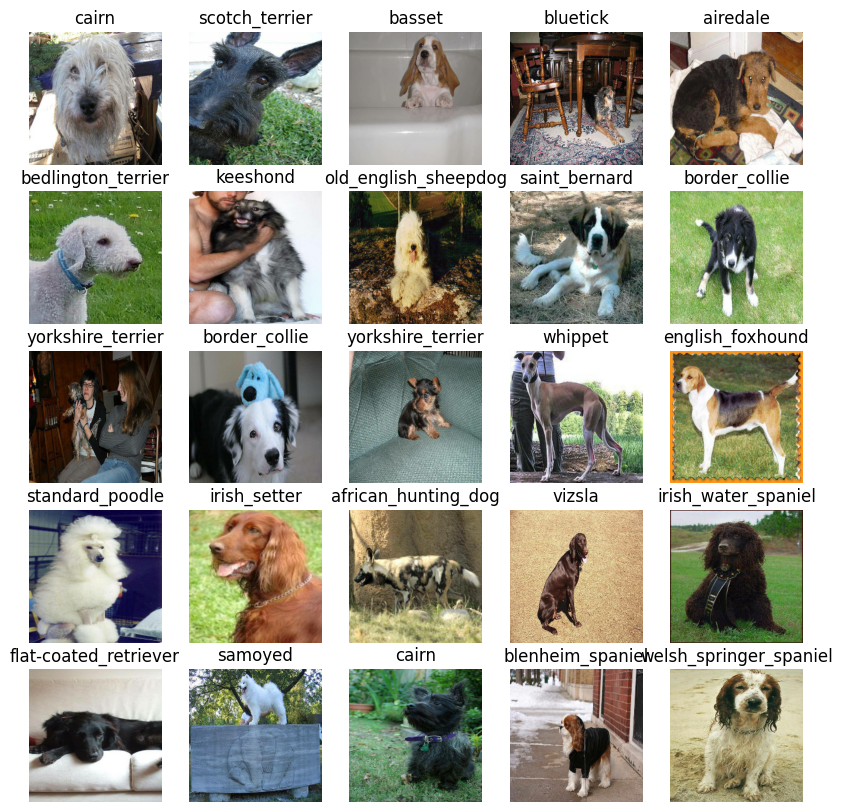

In [31]:
show_25_images(val_images, val_labels)

##Building a model
Before we build a model, there are a few things we need to define:

* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.
* These things will be standard practice with whatever machine learning model
 you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [32]:
#  setup the Inpput imgae size
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
#  output image size
OUTPUT_SHAPE = len(unique_breeds)
#  setup model url from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to use the Keras API.

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.
We'll take a look at the code first, then dicuss each part.

In [33]:
#  create a function to build a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building a model with :", model_url)

  # setup the model layers
  model = tf.keras.Sequential([
      th.KerasLayer(model_url), # layer 1 (input layer)
      tf.keras.layers.Dense(units=output_shape,
                            activation='softmax') # Layer 2 (output layer)
  ])

  #  compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  #Build the mo del
  model.build(input_shape)

  return model


In [34]:
model = create_model()
model.summary()

Building a model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training erly if a model stops improving

We will create two callbacks, one for tensorboard which helps track our models progress and another for early stopping which prvents our model from training for too long

## TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:

  1. Load the TensorBoard notebook extesion
  2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our models `fit()` function
  3. Visualize our models training logs with the %tensorboard magic function(we'll do this after model training)

In [35]:
#  Load TensorBoard notebook extension
%load_ext tensorboard

In [36]:
import datetime
import os

# create a function to build a Tensorboard callback
def create_tensorboard_callback():
  #  create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Dogvision/logs",
                        #  Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback
It stops our model early to avoid overfitting by stopping training if certain evaluation metric stops improving

In [37]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

##Traning a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [38]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Lets create a function which trains a model
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for and callbacks we'd like to use
* Return the model

In [39]:
#  Build a function to train and return a trained model
def train_model():
  """
  Train a given model and returns the trained version
  """

  # create a model
  model = create_model()

  # Create new TensorBoard session eveytime we train a model
  tensorboard = create_tensorboard_callback()

  # fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data = val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  return model

In [40]:
#  fit the model to the data
model = train_model()

Building a model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 185s 6s/step - loss: 4.6966 - accuracy: 0.0988 - val_loss: 3.4716 - val_accuracy: 0.1950
Epoch 2/100
25/25 [==============================] - 4s 162ms/step - loss: 1.7006 - accuracy: 0.6650 - val_loss: 2.1616 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 6s 221ms/step - loss: 0.5734 - accuracy: 0.9438 - val_loss: 1.6756 - val_accuracy: 0.6100
Epoch 4/100
25/25 [==============================] - 4s 145ms/step - loss: 0.2597 - accuracy: 0.9825 - val_loss: 1.4591 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 5s 203ms/step - loss: 0.1504 - accuracy: 0.9962 - val_loss: 1.3860 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 5s 188ms/step - loss: 0.1029 - accuracy: 1.0000 - val_loss: 1.3246 - val_accuracy: 0.6900
Epoch 7/100
25/25 [============================

## Tensorboard progress of model visualization
* using tesorboard magic call (%tensorboard) adn file path to logs we can visualize the progress

In [41]:
%tensorboard --logdir /content/drive/My\ Drive/Dogvision/logs --port=5000


<IPython.core.display.Javascript object>

In [42]:
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 3s 182ms/step


array([[9.2811871e-04, 1.7007771e-04, 4.8813314e-04, ..., 2.0431547e-04,
        1.7884174e-04, 7.8590689e-03],
       [2.5615382e-03, 9.4363262e-05, 1.1685429e-02, ..., 2.7920530e-04,
        2.7487834e-03, 4.3616805e-04],
       [1.8527278e-05, 3.4515056e-04, 6.5524982e-05, ..., 1.0125573e-04,
        2.0964488e-03, 2.7262543e-03],
       ...,
       [4.7797625e-05, 4.5975863e-05, 3.6558693e-05, ..., 1.7683495e-04,
        2.5800098e-04, 7.3367279e-05],
       [1.6037701e-03, 8.7845867e-05, 5.6334440e-05, ..., 1.4366844e-04,
        1.2918790e-04, 3.9062088e-03],
       [3.5528888e-04, 4.7280359e-06, 1.3571848e-04, ..., 2.0943652e-03,
        5.1448413e-04, 9.5418414e-05]], dtype=float32)

In [43]:
np.sum(predictions[0])

0.9999999

In [44]:
# first prediction
index = 81
print(predictions[0])
print(f"max value (probability of prediction):{np.max(predictions[index])}" )
print(f"Sum : {np.sum(predictions[index])}")
print(f"max index: {np.argmax(predictions[index])}")
print(f"predicted label: {unique_breeds[np.argmax(predictions[index])]}")


[9.2811871e-04 1.7007771e-04 4.8813314e-04 2.6845239e-04 1.3773374e-03
 9.2921116e-05 5.5335730e-02 6.9812412e-04 3.6486144e-05 1.7062692e-03
 2.1169682e-04 6.4806947e-05 3.2241365e-03 6.4631004e-04 5.9695893e-05
 2.6750308e-04 1.7210265e-05 2.5125229e-01 8.4802059e-06 1.7891519e-04
 1.3189706e-03 7.5787444e-05 7.4585323e-06 1.4775200e-03 2.7249960e-05
 1.7563479e-04 1.4696075e-01 2.1923644e-05 2.4927680e-03 7.3704745e-05
 9.8023633e-04 5.8988575e-03 5.7820277e-04 3.0957907e-04 3.1184987e-05
 3.9877683e-02 5.4501425e-06 1.1560251e-03 5.0452836e-05 3.0904026e-05
 4.0108287e-03 3.0615553e-05 1.2427864e-04 5.0252635e-05 1.3488390e-04
 2.6788042e-04 2.0236723e-05 8.0287711e-05 3.7688436e-04 8.7853958e-05
 2.1801734e-05 1.8356231e-04 2.5038471e-04 1.4572068e-04 8.7079039e-05
 6.1901766e-05 9.8292345e-05 3.0944597e-03 1.3591517e-03 1.0310907e-01
 8.4718643e-04 2.0180720e-05 6.6073886e-03 2.5441430e-05 8.9794066e-04
 1.4213734e-02 7.7706500e-05 6.9675053e-04 9.8394612e-03 3.3576906e-04
 1.467

In [45]:
np.sum(predictions[0])

0.9999999

In [46]:
# Turn prediction probabilities into their respective label (easier to understand)

def get_pred_label(predicted_probabilities):
  """
  Turns an array of prediction probabilities into a label.

  """

  return unique_breeds[np.argmax(predicted_probabilities)]



In [47]:
# Get a predicted label based on an array of prediction probabilities
pred_label = predictions[20]
pred_label = get_pred_label(pred_label)
pred_label

'flat-coated_retriever'

In [48]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [49]:
#  create a function to unbatch the batch dataset
images_ = []
labels_ = []
def unbatchify(dataset):
  # Loop through the dataset
  for image, label in dataset.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])

  return images_, labels_



In [50]:
#  unbatch the validation data

val_images, val_labels = unbatchify(val_data)
val_images

[array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [51]:
get_pred_label(val_labels[0])

'affenpinscher'

In [52]:
get_pred_label(predictions[0])

'border_terrier'

Now we've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images
Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [53]:
def plot_pred(labels, images, prediction_probabilities, n=1):
  """
  view predicted label, truth label, probability, and image
  """
  pred_prob = prediction_probabilities[n]
  image = images[n]
  truth_label = labels[n]
  # get pred label
  pred_label = get_pred_label(pred_prob)

  # plot the image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == truth_label:
    color = 'green'
  else:
    color = 'red'
  # title above image
  plt.title("{} {:0.2f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    truth_label),
                                    color=color)



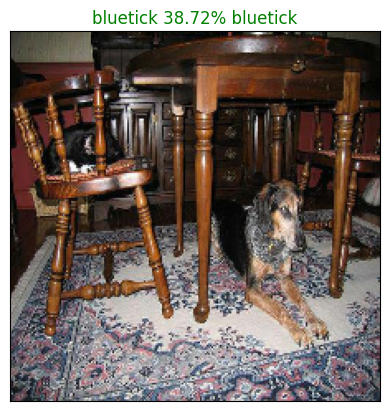

In [54]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=3)


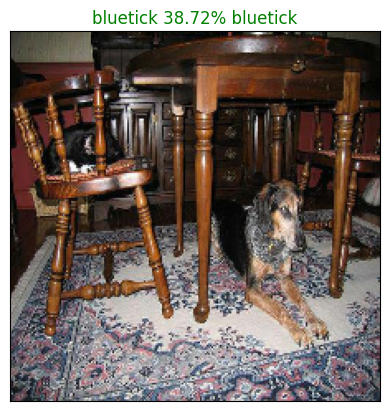

In [55]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=3)

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
     * Prediction probabilities indexes
     * Prediction probabilities values
     * Prediction labels
     * Plot the top 10 prediction probability values and labels, coloring the true label green.

In [56]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  plus the top 10 highest prediction confidences along with the truth label for sample n.

  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  #  get the prediction label
  pred_label = get_pred_label(pred_prob)

  # find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # plot the bar graph
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation='vertical')
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

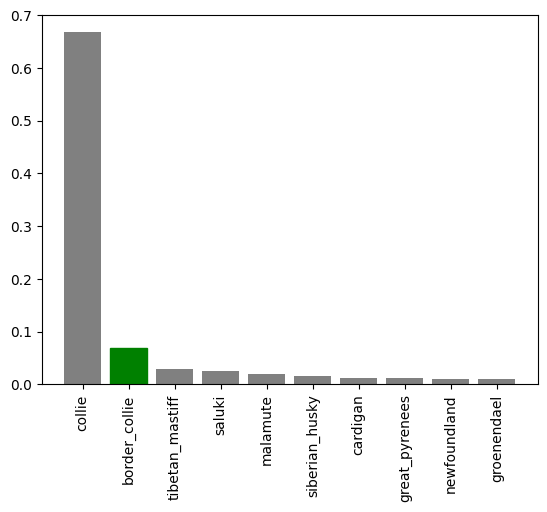

In [57]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Wonderful! Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

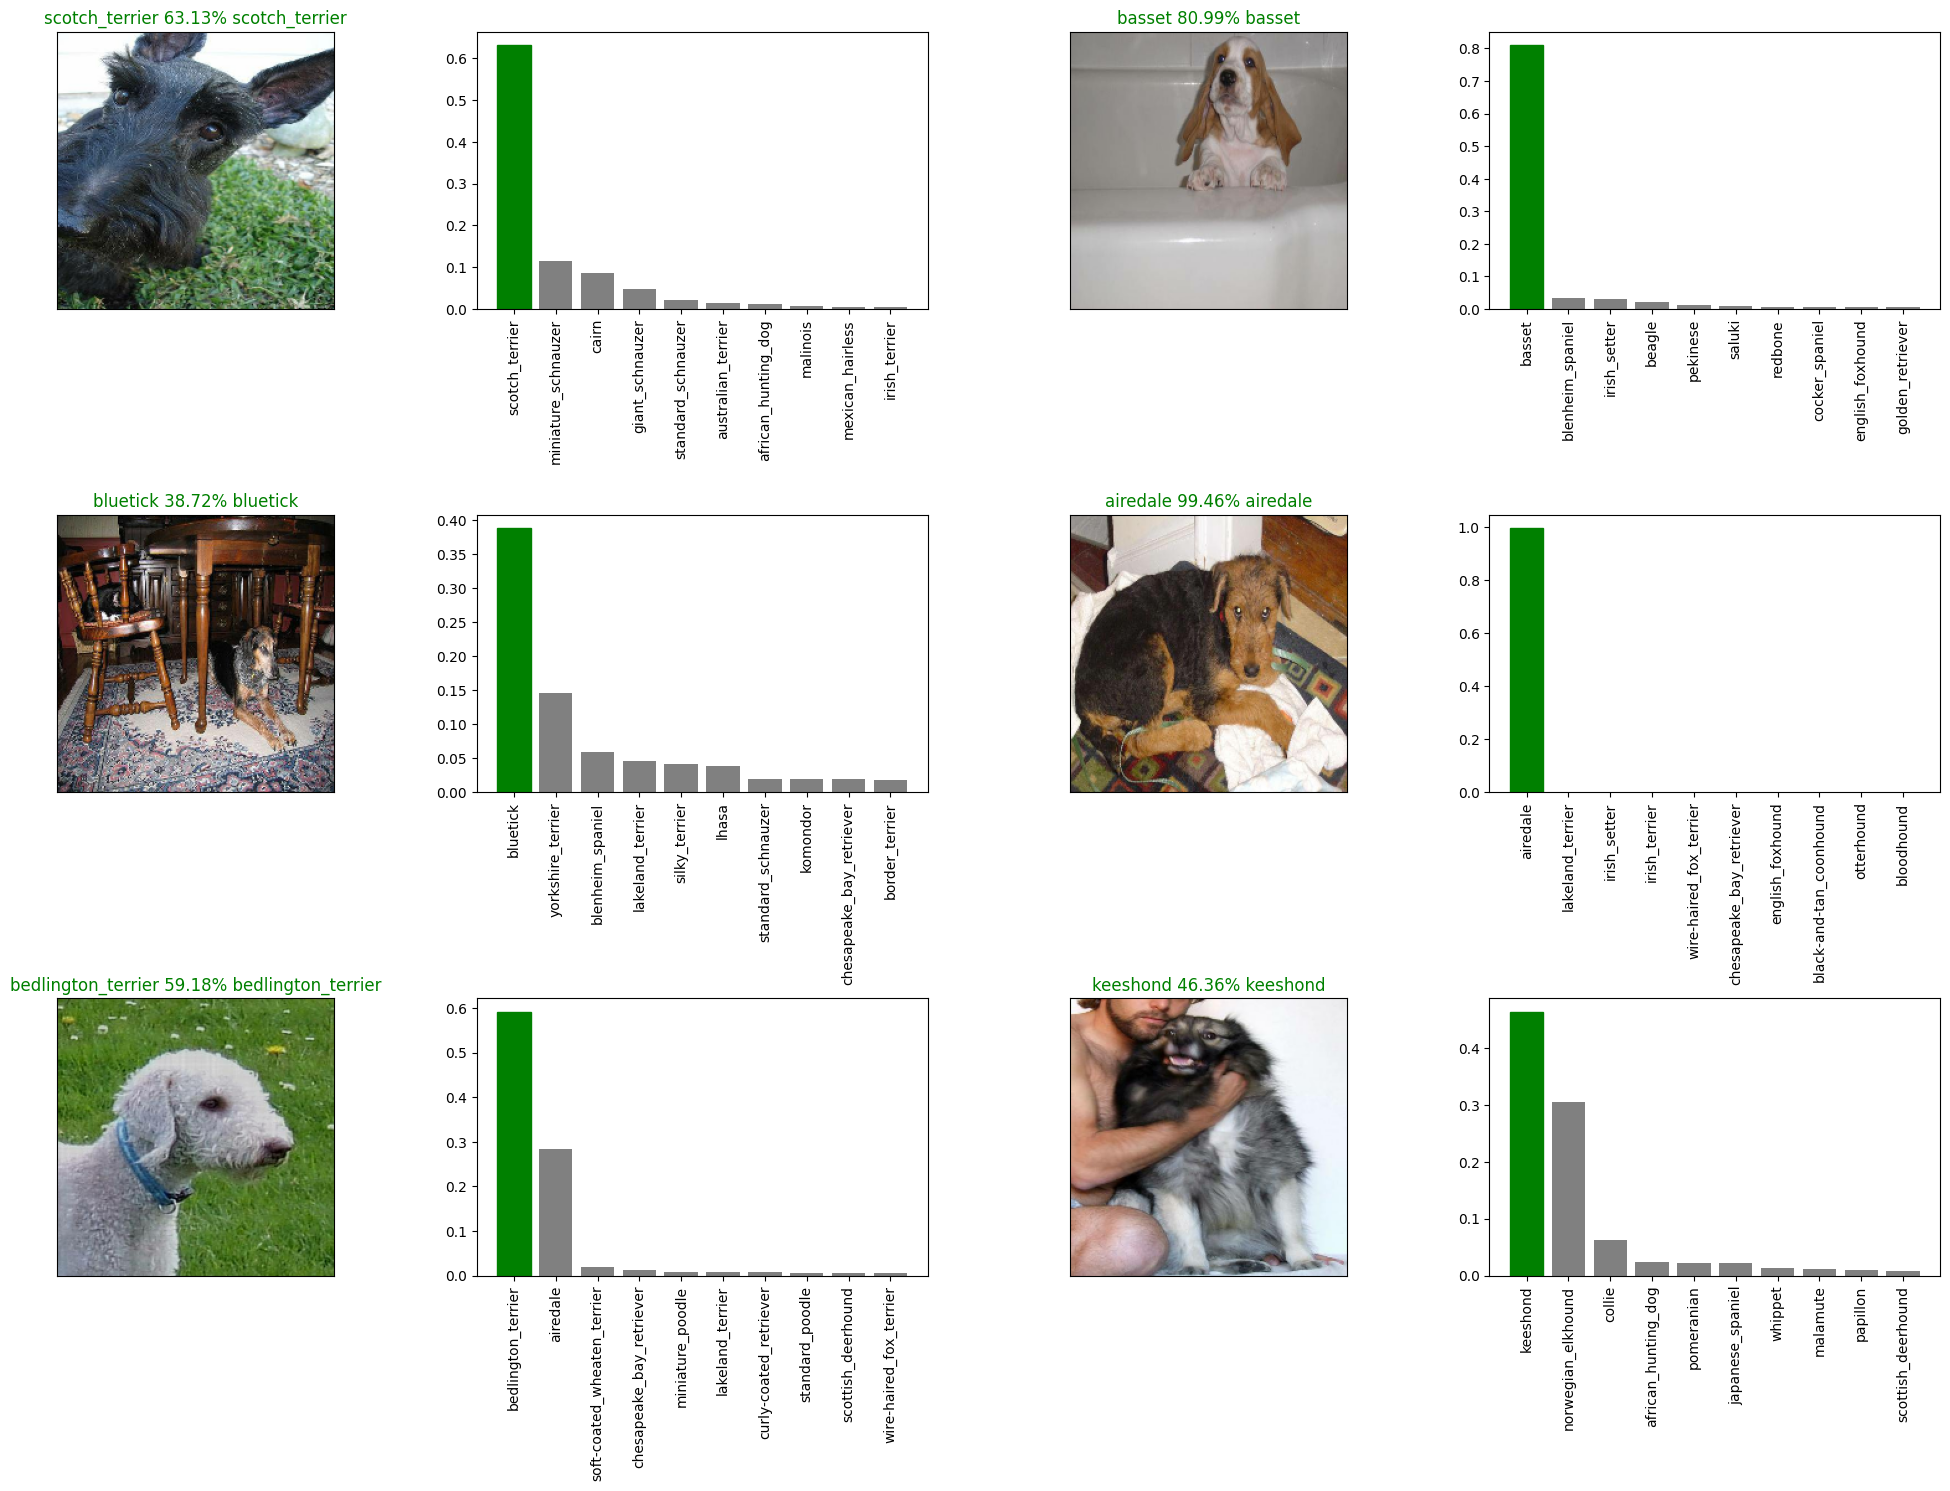

In [58]:
# Let's check a few predictions and their different values
i_multiplier=1
num_rows=3
num_cols=2
num_images =num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
            labels=val_labels,
            n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()




In [59]:
#  function to list of labels from numerical values
def label_name(label):
  label__=[]
  """
  Returns name of breed through `get_pred_label()` function and save it to a list
  """
  for i in range(len(label) - 1):
    label_prob = get_pred_label(label[i])
    label__.append(label_prob)

  return label__

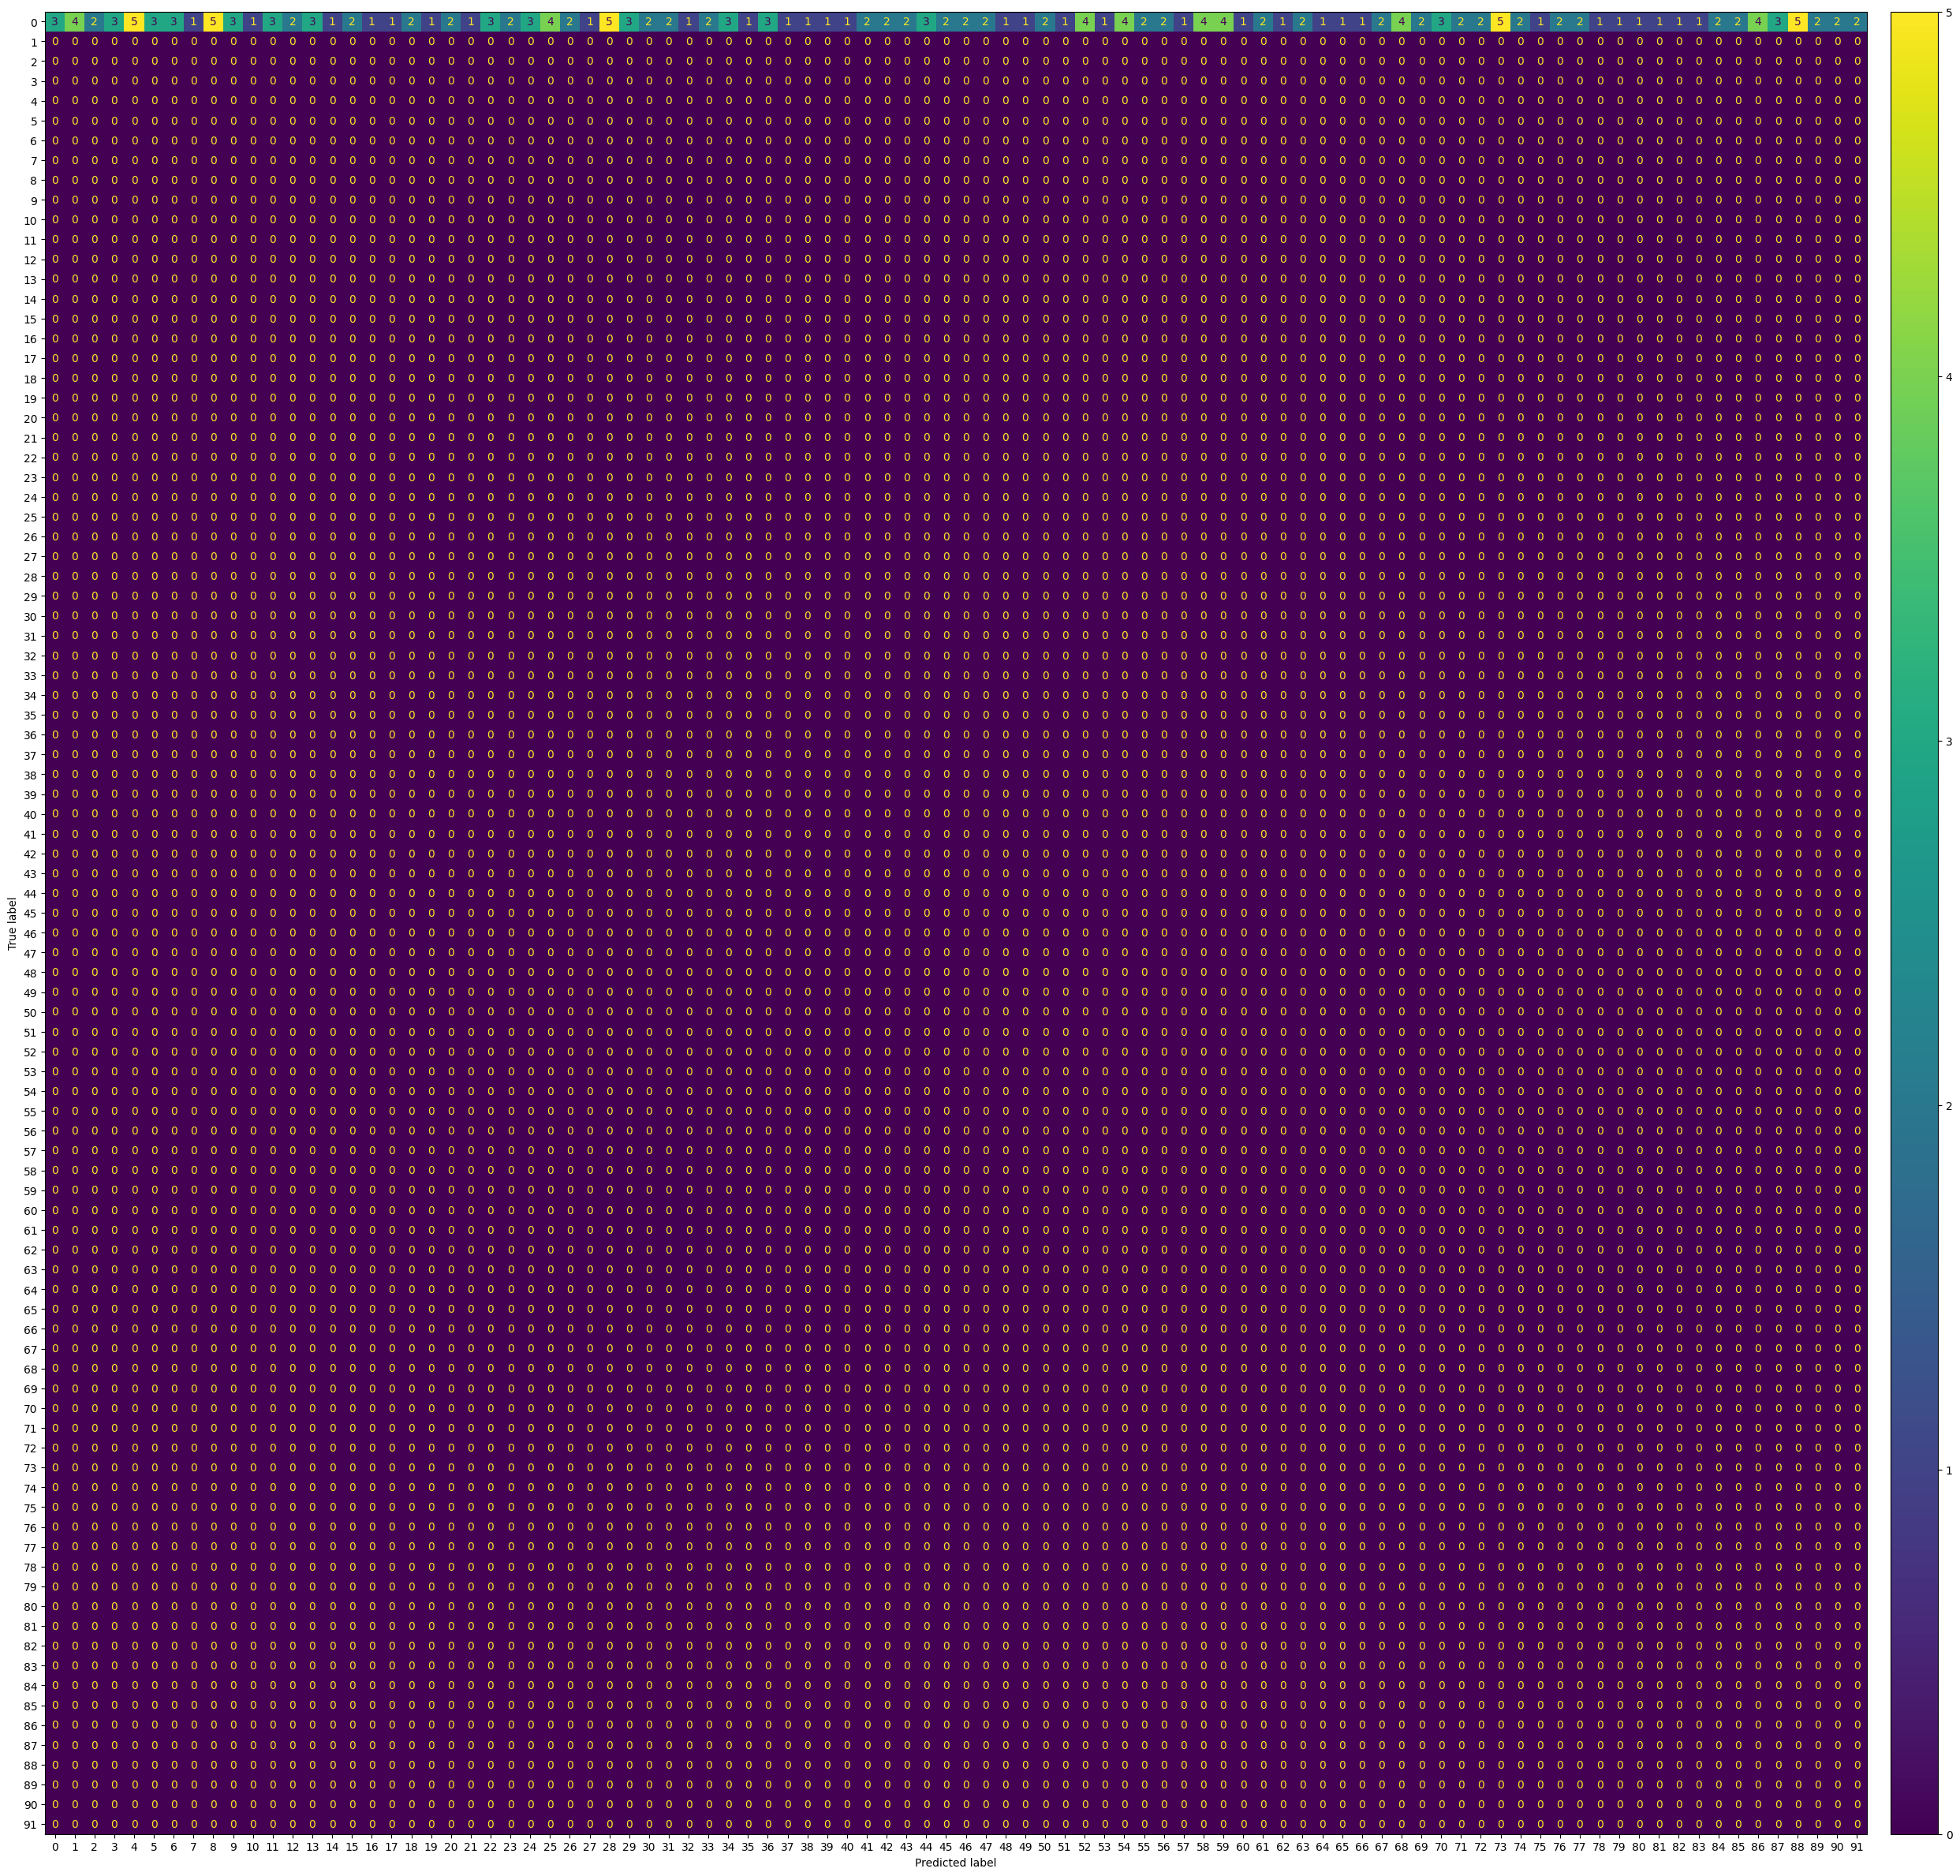

In [60]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
true_labelss = label_name(val_labels)
pred_labelss = label_name(predictions)
cm = confusion_matrix(true_labelss, pred_labelss)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
fig, ax = plt.subplots(figsize=(30, 30))

# Deactivate default colorbar
cmp.plot(ax=ax, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

##Saving and reloading a trained model

In [61]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
# Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dogvision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [62]:
# create a function to load a model
def load_model(model_path):
  """
   Loads a saved model from a specified path.

  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer': th.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [63]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dogvision/models/20240229-10341709202872-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Dogvision/models/20240229-10341709202872-1000-images-mobilenetv2-Adam.h5'

In [64]:
#
loaded_1000_image_model = load_model('/content/drive/MyDrive/Dogvision/models/20231004-08041696406663-1000-images-mobilenetv2-Adam.h5')


Loading saved model from: /content/drive/MyDrive/Dogvision/models/20231004-08041696406663-1000-images-mobilenetv2-Adam.h5


In [65]:
model.evaluate(val_data)

7/7 [==============================] - 1s 114ms/step - loss: 1.2230 - accuracy: 0.6900


[1.2229673862457275, 0.6899999976158142]

In [66]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 2s 160ms/step - loss: 1.3537 - accuracy: 0.6650


[1.3537310361862183, 0.6650000214576721]

##Training a big dog model 🐶 (on the full data)

In [67]:
len(x), len(y)


(10222, 10222)

In [68]:
# Create a data batch with the full data set
full_data = create_data_batches(x, y)

Creating training data batches....


In [69]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [70]:
# create a model
full_model = create_model()

Building a model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [71]:
# create a tensorboard callback
full_model_tensorboard = create_tensorboard_callback()
#  create a earlystopping callback
full_model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                                     patience=3)

In [ ]:
#  fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_earlystopping_callback])

Epoch 1/100
320/320 [==============================] - 49s 140ms/step - loss: 1.3472 - accuracy: 0.6696
Epoch 2/100
320/320 [==============================] - 42s 132ms/step - loss: 0.3971 - accuracy: 0.8811
Epoch 3/100
320/320 [==============================] - 40s 125ms/step - loss: 0.2357 - accuracy: 0.9358
Epoch 4/100
320/320 [==============================] - 42s 130ms/step - loss: 0.1537 - accuracy: 0.9650
Epoch 5/100
320/320 [==============================] - 40s 125ms/step - loss: 0.1060 - accuracy: 0.9788
Epoch 6/100
320/320 [==============================] - 43s 134ms/step - loss: 0.0779 - accuracy: 0.9856
Epoch 7/100
320/320 [==============================] - 44s 138ms/step - loss: 0.0597 - accuracy: 0.9914
Epoch 8/100
320/320 [==============================] - 43s 135ms/step - loss: 0.0460 - accuracy: 0.9951


In [ ]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

In [ ]:
full_model = load_model("drive/MyDrive/Dogvision/models/20231004-09041696410251-full-image-set-mobilenetv2-Adam.h5")

In [ ]:
# Load test image filename
test_path = "/content/drive/MyDrive/Dogvision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
#  create test data batch
test_data = create_data_batches(x=test_filenames, test_data=True)

In [ ]:
test_data

**Note** testing all images on full model is gonna take a fairly long time

In [ ]:
# make prediction on test data
test_predictions = full_model.predict(test_data,
                                      verbose=1)

In [ ]:
#  save predictions (Numpy array) to csv file (for access later)
np.savetxt("drive/MyDrive/Dogvision/preds_array.csv", test_predictions, delimiter=',')

In [ ]:
#  Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt('drive/MyDrive/Dogvision/preds_array.csv', delimiter=',')

# preparing test submission file
required format:
id column
column for each breed

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a * * column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
#  create a pandas dataframe with empty columns
import pandas as pd

preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
preds_df.head()

In [ ]:
import os
# Append test image ID to prediction DataFrame
test_path = "/content/drive/MyDrive/Dogvision/test/"

test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [ ]:
#  Add the preds probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
# save our preds dataframe to csv for submission to kaggle
preds_df.to_csv('drive/MyDrive/Dogvision/full_model_predictions_submission_1_mobilenetV2.csv',
                index=False)